In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, '/home/jupyter/')
from hourly_pollution_prediction.process_and_join.bbox import * 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#for image inpainting
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
import cv2 as cv
import xesmf as xe
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
from pathlib import Path


In [2]:
df = pd.read_csv("../../data/tempo_data/no2_tempo_files_df.csv")

timestamps_dt = pd.to_datetime(df['timestamp_ct'])
unique_months = timestamps_dt.dt.to_period('M').unique()

# Compare to a Period object, not a string
unique_months = [month for month in unique_months if month != pd.Period('2025-06', freq='M')]

In [4]:
ca_daily = pd.DataFrame()
la_daily = pd.DataFrame()
ca_hourly = pd.DataFrame()
la_hourly = pd.DataFrame()
ca_daily_max = pd.DataFrame()
la_daily_max = pd.DataFrame()

for month in unique_months:
    month_str = str(month)

    month_timestamps = timestamps_dt[timestamps_dt.dt.to_period('M') == month]
    days =month_timestamps.dt.to_period('d').unique()

    # LOOP THROUGH DAYS
    for day in days:
        day_str = str(day)

        ds = xr.open_dataset(f'../../data/tempo_data/no2_daily_files/tempo_{day_str}.nc', engine='netcdf4')

        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere'].where(
            ds['main_data_quality_flag'] == 0, other=np.nan
        )


        ds = ds.where(
            (ds.longitude >= -94.04159013340133) & (ds.longitude <= -88.81557807968079) &
            (ds.latitude >= 28.929616299252984) & (ds.latitude <= 33.01959948618486),
            drop=True
        )
        ds = ds[["vertical_column_troposphere"]]
        timestamp = day.to_timestamp()

        # ds['time'] = ds['time'].dt.floor('D')  # or .dt.normalize()

        timestamp_for_day = day.to_timestamp()
        ds = ds.assign_coords(day=timestamp_for_day)

        # Clip to LA boundary
        shapefile = gpd.read_file("louisiana.geojson")
        ca_shapefile = gpd.read_file("cancer_alley_shapefile/cancer_alley_polygon.shp")
        ds = ds.rio.write_crs("EPSG:4326")  # assuming your data is in WGS84

        # Clip to shape
        LA_ds = ds.rio.clip(shapefile.geometry, shapefile.crs, drop=True)
        Cancer_alley_ds = ds.rio.clip(ca_shapefile.geometry, shapefile.crs, drop=True)
        LA_ds = LA_ds.drop_vars('spatial_ref')
        Cancer_alley_ds = Cancer_alley_ds.drop_vars('spatial_ref')

        # Hourly max
        LA_ds_max = LA_ds[["vertical_column_troposphere"]]
        LA_ds_max['time'] = LA_ds_max['time'].dt.floor('D')  # or .dt.normalize()
        ds_daily_max = LA_ds_max.groupby('time').max()
        LA_ds_max = ds_daily_max.max(dim='time')
        LA_ds_max = LA_ds_max.assign_coords(day=timestamp_for_day)
        hourly_mean_max_la = LA_ds_max.mean(dim=['latitude','longitude'], keep_attrs=True)
        df_daily_max_la = pd.DataFrame({
            'vertical_column_troposphere': [float(hourly_mean_max_la['vertical_column_troposphere'])],
            'day': day 
        })
        df_daily_max_la['vertical_column_troposphere']=df_daily_max_la['vertical_column_troposphere']/1000000000000000
      
        ca_ds_max = Cancer_alley_ds[["vertical_column_troposphere"]]
        ca_ds_max['time'] = ca_ds_max['time'].dt.floor('D')  # or .dt.normalize()
        ds_daily_max = ca_ds_max.groupby('time').max()
        ca_ds_max = ds_daily_max.max(dim='time')
        hourly_mean_max_ca = ca_ds_max.mean(dim=['latitude','longitude'], keep_attrs=True)
        df_daily_max_ca = pd.DataFrame({
            'vertical_column_troposphere': [float(hourly_mean_max_ca['vertical_column_troposphere'])],
            'day': day 
        })
        df_daily_max_ca['vertical_column_troposphere']=df_daily_max_ca['vertical_column_troposphere']/1000000000000000
      

        #Hourly mean
        hourly_mean_LA = LA_ds.mean(dim=['latitude','longitude'], keep_attrs=True)
        df_hourly_mean_LA = hourly_mean_LA[['vertical_column_troposphere']].to_dataframe().reset_index()
        df_hourly_mean_LA['vertical_column_troposphere']=df_hourly_mean_LA['vertical_column_troposphere']/1000000000000000
        hourly_mean_ca = Cancer_alley_ds.mean(dim=['latitude','longitude'], keep_attrs=True)
        df_hourly_mean_ca = hourly_mean_ca[['vertical_column_troposphere']].to_dataframe().reset_index()
        df_hourly_mean_ca['vertical_column_troposphere']=df_hourly_mean_ca['vertical_column_troposphere']/1000000000000000

        #Daily mean
        daily_mean_LA = LA_ds.mean(dim='time', keep_attrs=True)
        daily_mean_ca = Cancer_alley_ds.mean(dim='time', keep_attrs=True)

        daily_mean_LA = daily_mean_LA.mean(dim=['latitude','longitude'], keep_attrs=True)
        daily_mean_LA = pd.DataFrame({
            'vertical_column_troposphere': [float(daily_mean_LA['vertical_column_troposphere'])],
            'day': day 
        })
        daily_mean_LA['vertical_column_troposphere']=daily_mean_LA['vertical_column_troposphere']/1000000000000000

        daily_mean_ca = daily_mean_ca.mean(dim=['latitude','longitude'], keep_attrs=True)
        daily_mean_ca = pd.DataFrame({
            'vertical_column_troposphere': [float(daily_mean_ca['vertical_column_troposphere'])],
            'day': day 
        })
        daily_mean_ca['vertical_column_troposphere']=daily_mean_ca['vertical_column_troposphere']/1000000000000000

        ca_daily = pd.concat([ca_daily, daily_mean_ca], axis=0)
        la_daily = pd.concat([la_daily, daily_mean_LA], axis=0)
        la_hourly = pd.concat([la_hourly, df_hourly_mean_LA], axis=0)
        ca_hourly = pd.concat([ca_hourly, df_hourly_mean_ca], axis=0)
        ca_daily_max = pd.concat([ca_daily_max, df_daily_max_ca], axis=0)
        la_daily_max = pd.concat([la_daily_max, df_daily_max_la], axis=0)

        
ca_daily.to_csv('cancer_alley_daily_means.csv')
la_daily.to_csv('louisiana_daily_means.csv')
la_hourly.to_csv('louisiana_hourly_means.csv')
ca_hourly.to_csv('cancer_alley_hourly_means.csv')
la_daily_max.to_csv('louisiana_dailymax.csv')
ca_daily_max.to_csv('cancer_alley_dailymax.csv')



In [5]:
ca_daily= pd.read_csv('cancer_alley_daily_means.csv')
ca_daily.rename(columns={'vertical_column_troposphere':'vertical_column_troposphere_canceralley'}, inplace=True)

la_daily=pd.read_csv('louisiana_daily_means.csv')
la_daily.rename(columns={'vertical_column_troposphere':'vertical_column_troposphere_LA'}, inplace=True)

la_hourly=pd.read_csv('louisiana_hourly_means.csv')
la_hourly.rename(columns={'vertical_column_troposphere':'vertical_column_troposphere_LA'}, inplace=True)

ca_hourly=pd.read_csv('cancer_alley_hourly_means.csv')
ca_hourly.rename(columns={'vertical_column_troposphere':'vertical_column_troposphere_canceralley'}, inplace=True)


ca_daily_max=pd.read_csv('cancer_alley_dailymax.csv')
ca_daily_max.rename(columns={'vertical_column_troposphere':'vertical_column_troposphere_canceralley'}, inplace=True)

la_daily_max=pd.read_csv('louisiana_dailymax.csv')
la_daily_max.rename(columns={'vertical_column_troposphere':'vertical_column_troposphere_LA'}, inplace=True)


In [11]:
ca_daily

,Unnamed: 0,vertical_column_troposphere_canceralley,day
0,0,3.006303,2023-08-02
1,0,2.675814,2023-08-04
2,0,2.044667,2023-08-05
3,0,1.670500,2023-08-06
4,0,0.998312,2023-08-07
...,...,...,...
105,0,4.718121,2025-05-01
106,0,2.842311,2025-05-02
107,0,2.092190,2025-05-03
108,0,2.392476,2025-05-04


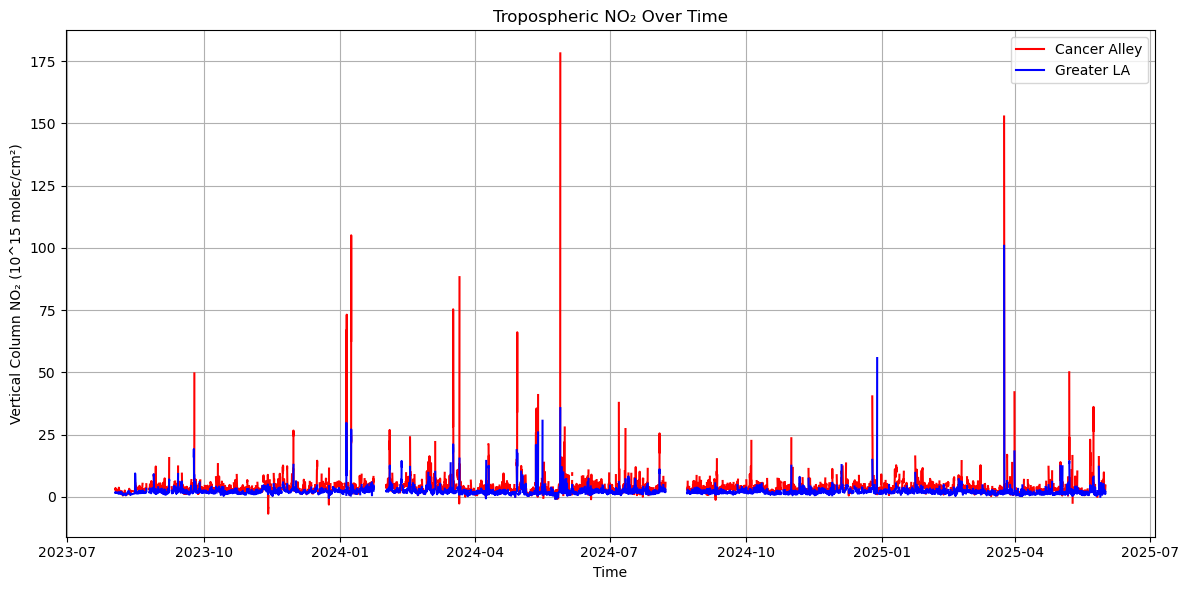

In [29]:
df=pd.merge(ca_hourly, la_hourly, on=['time','day'])

import matplotlib.pyplot as plt

# Ensure time is datetime
df['time'] = pd.to_datetime(df['time'])

plt.figure(figsize=(12, 6))

# Plot each line
plt.plot(df['time'], df['vertical_column_troposphere_canceralley'], label='Cancer Alley', color='red')
plt.plot(df['time'], df['vertical_column_troposphere_LA'], label='Greater LA', color='blue')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Vertical Column NO₂ (10^15 molec/cm²)')
plt.title('Tropospheric NO₂ Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
df_hours=df.groupby('hour')[['vertical_column_troposphere_canceralley', 'vertical_column_troposphere_LA']].mean().reset_index()

In [16]:
df.groupby('hour')[['vertical_column_troposphere_canceralley', 'vertical_column_troposphere_LA']].count()

,vertical_column_troposphere_canceralley,vertical_column_troposphere_LA
hour,,
2,1,1
4,8,8
5,11,11
6,58,59
7,372,416
8,906,933
9,640,640
10,607,607
11,595,595


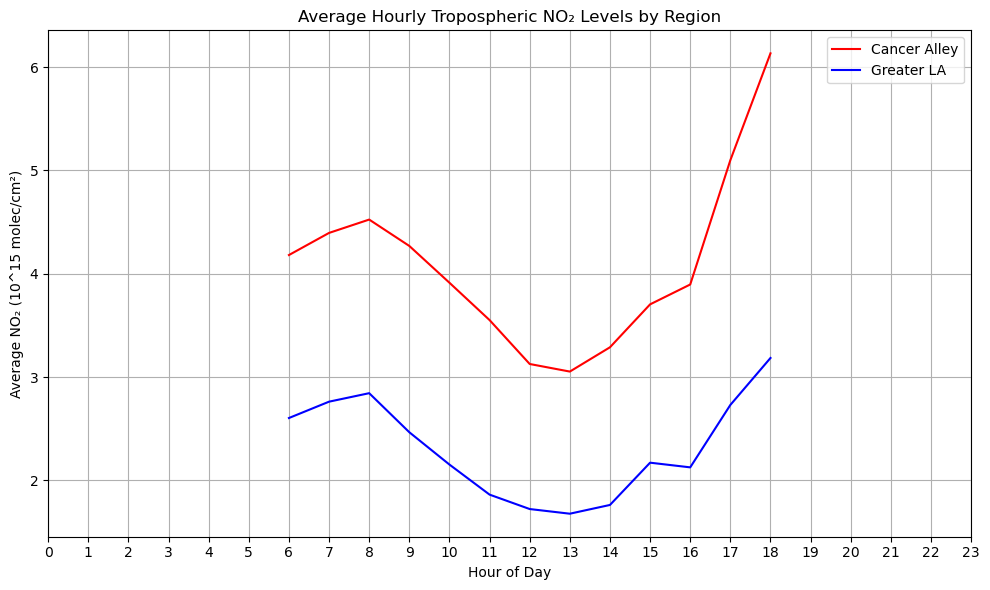

In [28]:
df_hours = df_hours[(df_hours['hour']>5) & (df_hours['hour']<19)]
plt.figure(figsize=(10, 6))
plt.plot(df_hours['hour'], df_hours['vertical_column_troposphere_canceralley'], label='Cancer Alley', color='red')
plt.plot(df_hours['hour'], df_hours['vertical_column_troposphere_LA'], label='Greater LA', color='blue')

plt.xlabel('Hour of Day')
plt.ylabel('Average NO₂ (10^15 molec/cm²)')
plt.title('Average Hourly Tropospheric NO₂ Levels by Region')
plt.xticks(range(0, 24))  # show all 24 hours
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
df_daily['day'].dtype

dtype('O')

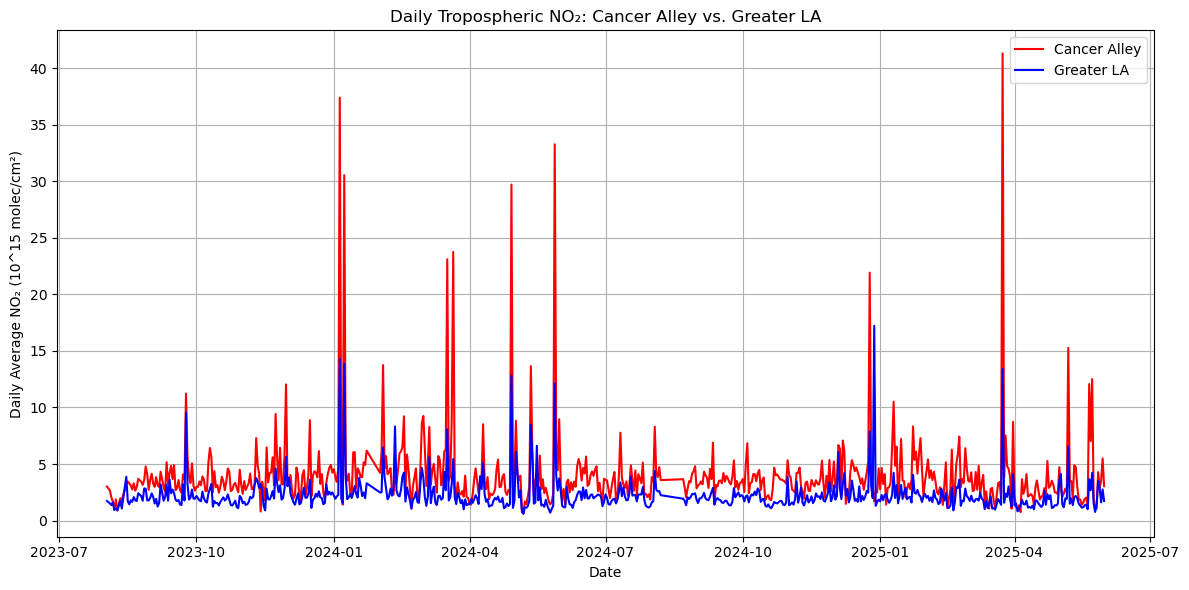

In [30]:
df_daily=pd.merge(ca_daily, la_daily, on=['day'])
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'day' is a datetime column
# df_daily['day'] = df_daily['day'].dt.to_timestamp()

df_daily['day'] = pd.to_datetime(df_daily['day'])

plt.figure(figsize=(12, 6))

plt.plot(df_daily['day'], df_daily['vertical_column_troposphere_canceralley'], label='Cancer Alley', color='red')
plt.plot(df_daily['day'], df_daily['vertical_column_troposphere_LA'], label='Greater LA', color='blue')

plt.xlabel('Date')
plt.ylabel('Daily Average NO₂ (10^15 molec/cm²)')
plt.title('Daily Tropospheric NO₂: Cancer Alley vs. Greater LA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
df_daily[df_daily['vertical_column_troposphere_canceralley']>20]

,Unnamed: 0_x,vertical_column_troposphere_canceralley,day,Unnamed: 0_y,vertical_column_troposphere_LA,day_of_week,month_year
150,0,37.379334,2024-01-05,0,14.268060,Friday,2024-01
153,0,30.528258,2024-01-08,0,13.839256,Monday,2024-01
214,0,23.091870,2024-03-17,0,8.070255,Sunday,2024-03
218,0,23.739703,2024-03-21,0,5.436145,Thursday,2024-03
257,0,29.700378,2024-04-29,0,12.837470,Monday,2024-04
286,0,33.261336,2024-05-28,0,12.125590,Tuesday,2024-05
481,0,21.907295,2024-12-25,0,7.887170,Wednesday,2024-12
570,0,41.296819,2025-03-24,0,13.388357,Monday,2025-03


/var/tmp/ipykernel_5654/3829819455.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_daily.groupby('day_of_week')[[


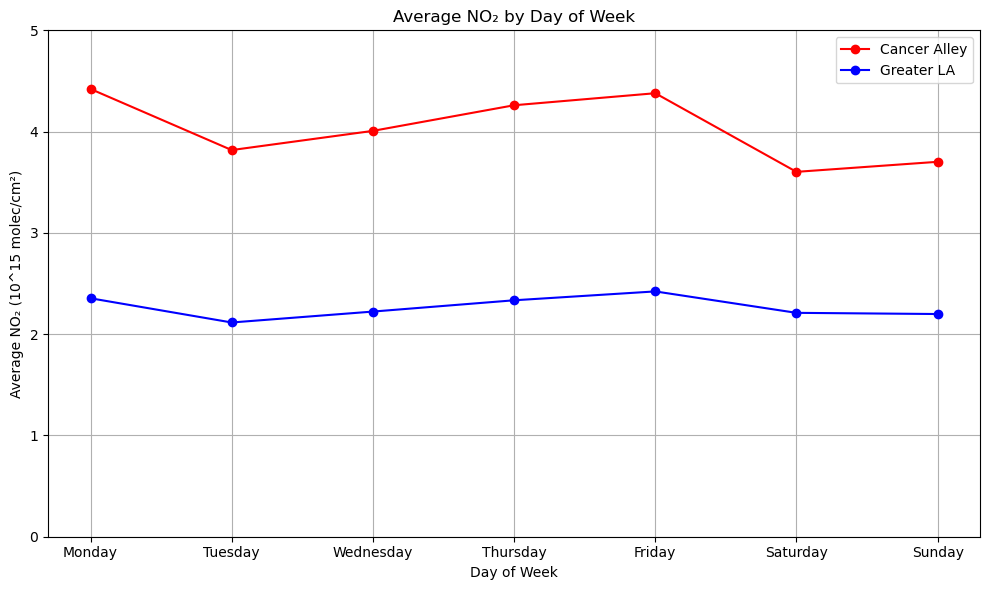

In [31]:
df_daily['day_of_week'] = df_daily['day'].dt.day_name()
from pandas.api.types import CategoricalDtype

# Define proper weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_dtype = CategoricalDtype(categories=weekday_order, ordered=True)

df_daily['day_of_week'] = df_daily['day_of_week'].astype(cat_dtype)

# Group and compute mean NO₂
df_grouped = df_daily.groupby('day_of_week')[[
    'vertical_column_troposphere_canceralley',
    'vertical_column_troposphere_LA'
]].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_grouped['day_of_week'], df_grouped['vertical_column_troposphere_canceralley'], label='Cancer Alley', marker='o', color='red')
plt.plot(df_grouped['day_of_week'], df_grouped['vertical_column_troposphere_LA'], label='Greater LA', marker='o', color='blue')
plt.ylim(0,5)
plt.title('Average NO₂ by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average NO₂ (10^15 molec/cm²)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


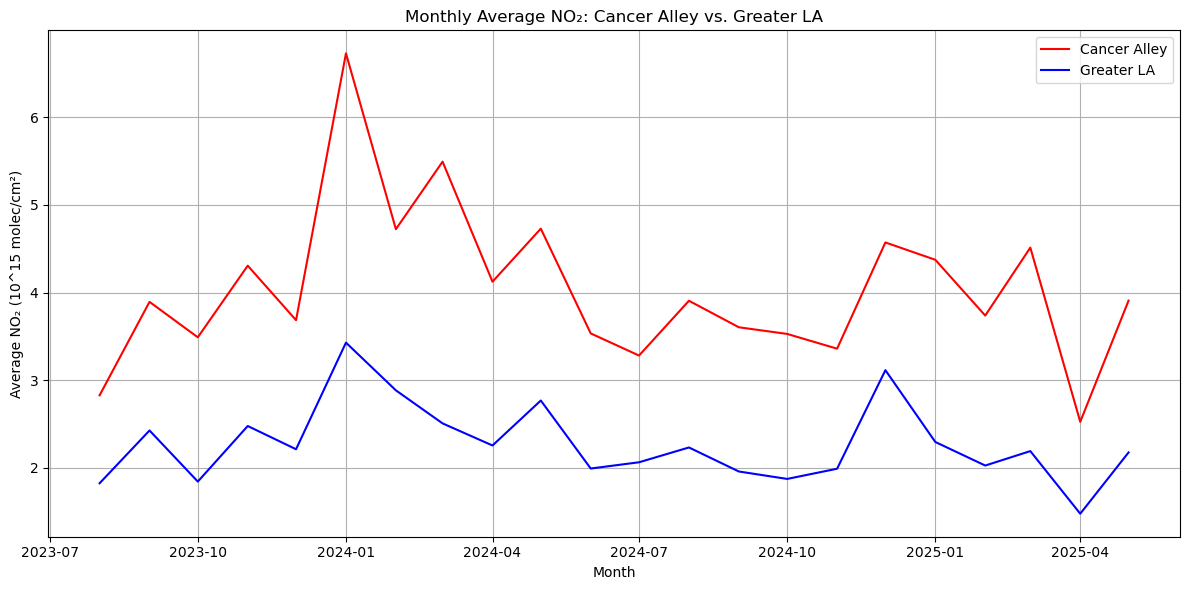

In [32]:
df_daily['month_year'] = df_daily['day'].dt.to_period('M').astype(str)

df_monthly = df_daily.groupby('month_year')[[
    'vertical_column_troposphere_canceralley',
    'vertical_column_troposphere_LA'
]].mean().reset_index()

df_monthly['month_year'] = pd.to_datetime(df_monthly['month_year'])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_monthly['month_year'], df_monthly['vertical_column_troposphere_canceralley'], label='Cancer Alley', color='red')
plt.plot(df_monthly['month_year'], df_monthly['vertical_column_troposphere_LA'], label='Greater LA', color='blue')

plt.xlabel('Month')
plt.ylabel('Average NO₂ (10^15 molec/cm²)')
plt.title('Monthly Average NO₂: Cancer Alley vs. Greater LA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


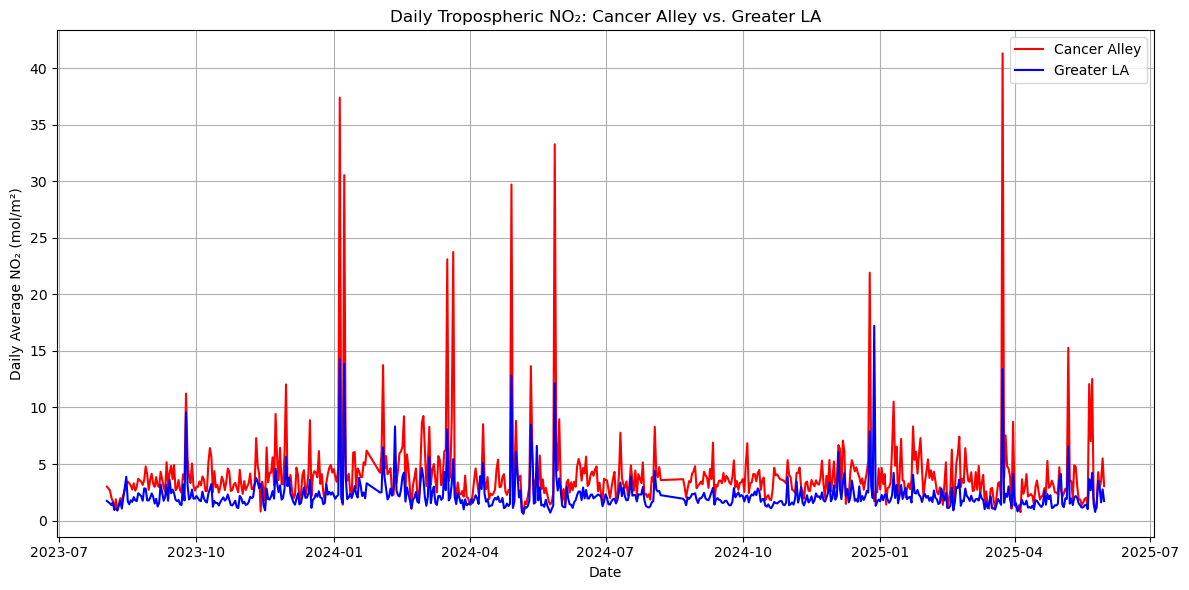

In [19]:
df_daily_max=pd.merge(ca_daily_max, la_daily_max, on=['day'])
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'day' is a datetime column
# df_daily['day'] = df_daily['day'].dt.to_timestamp()

df_daily['day'] = pd.to_datetime(df_daily['day'])

plt.figure(figsize=(12, 6))

plt.plot(df_daily['day'], df_daily['vertical_column_troposphere_canceralley'], label='Cancer Alley', color='red')
plt.plot(df_daily['day'], df_daily['vertical_column_troposphere_LA'], label='Greater LA', color='blue')

plt.xlabel('Date')
plt.ylabel('Daily Average NO₂ (mol/m²)')
plt.title('Daily Tropospheric NO₂: Cancer Alley vs. Greater LA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
# Break out by parish or look at lake charles
# Look at lake charles specifically -- 
# ask Amelia what areas we care about

# Lake Charles vs. Lafayette
# Shift north, shift south
## Do some null checks

In [24]:
facility = pd.read_csv("../../data/facility_data/facility_map.csv")
len(facility[facility['State']=='LA']['Facility ID'].unique())

30

In [26]:
facility['Facility Name'].unique()

array(['Copper Station', 'Oklaunion Power Station', 'Limestone',
       'Louisiana 1', 'R S Nelson', 'Coughlin Power Station',
       'Teche Power Station', 'Little Gypsy', 'Ninemile Point',
       'Sterlington', 'Arsenal Hill Power Plant', 'Lieberman Power Plant',
       'Houma', 'Big Cajun 1', 'Laredo', 'Nueces Bay',
       'Victoria Power Station', 'Lake Hubbard',
       'Mountain Creek Generating Station', 'Newman Power Station',
       'Lewis Creek', 'Sabine', 'Cedar Bayou', 'Greens Bayou',
       'T H Wharton', 'W A Parish', 'Knox Lee Power Plant',
       'Wilkes Power Plant', 'Jones Station', 'Nichols Station',
       'Plant X', 'Graham', 'Handley Generating Station', 'Morgan Creek',
       'Permian Basin', 'Stryker Creek', 'Trinidad', 'Decker Creek',
       'Silas Ray', 'Ray Olinger', 'Sim Gideon',
       'J Robert Massengale Generating Station', 'Leon Creek',
       'O W Sommers', 'V H Braunig', 'R W Miller', 'Sam Rayburn Plant',
       'Power Lane Steam Plant', 'Spencer', 'T 